## Course Assignment Instructions
You should have Python (version 3.8 or later) and Jupyter Notebook installed to complete this assignment. You will write code in the empty cell/cells below the problem. While most of this will be a programming assignment, some questions will ask you to "write a few sentences" in markdown cells. 

Submission Instructions:

Create a labs directory in your personal class repository (e.g., located in your home directory)
Clone the class repository
Copy this Jupyter notebook file (.ipynb) into your repo/labs directory
Make your edits, commit changes, and push to your repository
All submissions must be pushed before the due date to avoid late penalties. 

Labs are graded out of a 100 pts. Each day late is -10. For a max penalty of -50 after 5 days. From there you may submit the lab anytime before the semester ends for a max score of 50.  

Lab 7 is due on 4/21/25 

## Polynomial Regression and Interaction Regression

We will work with the diamonds dataset again. Here we load up the dataset and convert all factors to nominal type:

In [3]:
import pandas as pd
import numpy as np
from plotnine.data import diamonds

# Create a copy of the dataset
diamonds = diamonds.copy()

# Convert factor-like columns to nominal (unordered categorical)
diamonds['cut'] = pd.Categorical(diamonds['cut'], ordered=False)
diamonds['color'] = pd.Categorical(diamonds['color'], ordered=False)
diamonds['clarity'] = pd.Categorical(diamonds['clarity'], ordered=False)

# Print summary statistics (like skimr in R)
print("Summary Statistics:")
print(diamonds.describe(include='all'))

# Calculate and print the number of missing values per column
missing_counts = diamonds.isnull().sum()
print("\nMissing Values:")
print(missing_counts)


Summary Statistics:
               carat    cut  color clarity         depth         table  \
count   53940.000000  53940  53940   53940  53940.000000  53940.000000   
unique           NaN      5      7       8           NaN           NaN   
top              NaN  Ideal      G     SI1           NaN           NaN   
freq             NaN  21551  11292   13065           NaN           NaN   
mean        0.797940    NaN    NaN     NaN     61.749405     57.457184   
std         0.474011    NaN    NaN     NaN      1.432621      2.234491   
min         0.200000    NaN    NaN     NaN     43.000000     43.000000   
25%         0.400000    NaN    NaN     NaN     61.000000     56.000000   
50%         0.700000    NaN    NaN     NaN     61.800000     57.000000   
75%         1.040000    NaN    NaN     NaN     62.500000     59.000000   
max         5.010000    NaN    NaN     NaN     79.000000     95.000000   

               price             x             y             z  
count   53940.000000  5394

Given the information above, what are the number of columns in the raw X matrix?

There are 23 columns in the raw X matrix.

Verify this using code:

In [5]:
# Compute the number of columns
X_cat = pd.get_dummies(diamonds[['cut', 'color', 'clarity']], drop_first=True)

# Select numeric columns (exclude 'price' which is the response)
X_num = diamonds.drop(columns=['cut', 'color', 'clarity', 'price'])

# Combine numeric and encoded categorical predictors
X = pd.concat([X_num, X_cat], axis=1)

# Print number of columns in X
print("Number of columns in raw X matrix:", X.shape[1])


Number of columns in raw X matrix: 23


Would it make sense to use polynomial expansions for the variables cut, color and clarity? Why or why not?

No, it would not make sense to use polynomial expansions for the variables cut, color, and clarity because these are categorical (nominal) variables, not numeric. Polynomial terms are only meaningful for numeric, continuous variables — where higher powers capture non-linear trends.

Would it make sense to use log transformations for the variables cut, color and clarity? Why or why not?

No, it would not make sense to use log transformations for the variables cut, color, and clarity because they are categorical, not numeric. Log transformations are used to compress the scale of positive numeric variables

In order to ensure there is no time trend in the data, randomize the order of the diamond observations in D:.

In [8]:
# Randomize the order of diamond observations
diamonds_shuffled = diamonds.sample(frac=1, random_state=42).reset_index(drop=True)

print(diamonds_shuffled.head())


   carat        cut color clarity  depth  table  price     x     y     z
0   0.24      Ideal     G    VVS1   62.1   56.0    559  3.97  4.00  2.47
1   0.58  Very Good     F    VVS2   60.0   57.0   2201  5.44  5.42  3.26
2   0.40      Ideal     E    VVS2   62.1   55.0   1238  4.76  4.74  2.95
3   0.43    Premium     E    VVS2   60.8   57.0   1304  4.92  4.89  2.98
4   1.55      Ideal     E     SI2   62.3   55.0   6901  7.44  7.37  4.61


Let's also concentrate only on diamonds with <= 2 carats to avoid the issue we saw with the maximum. So subset the dataset. Create a variable n equal to the number of remaining rows as this will be useful for later. Then plot it.

Rows before filtering: 53940
Number of remaining rows: 52051


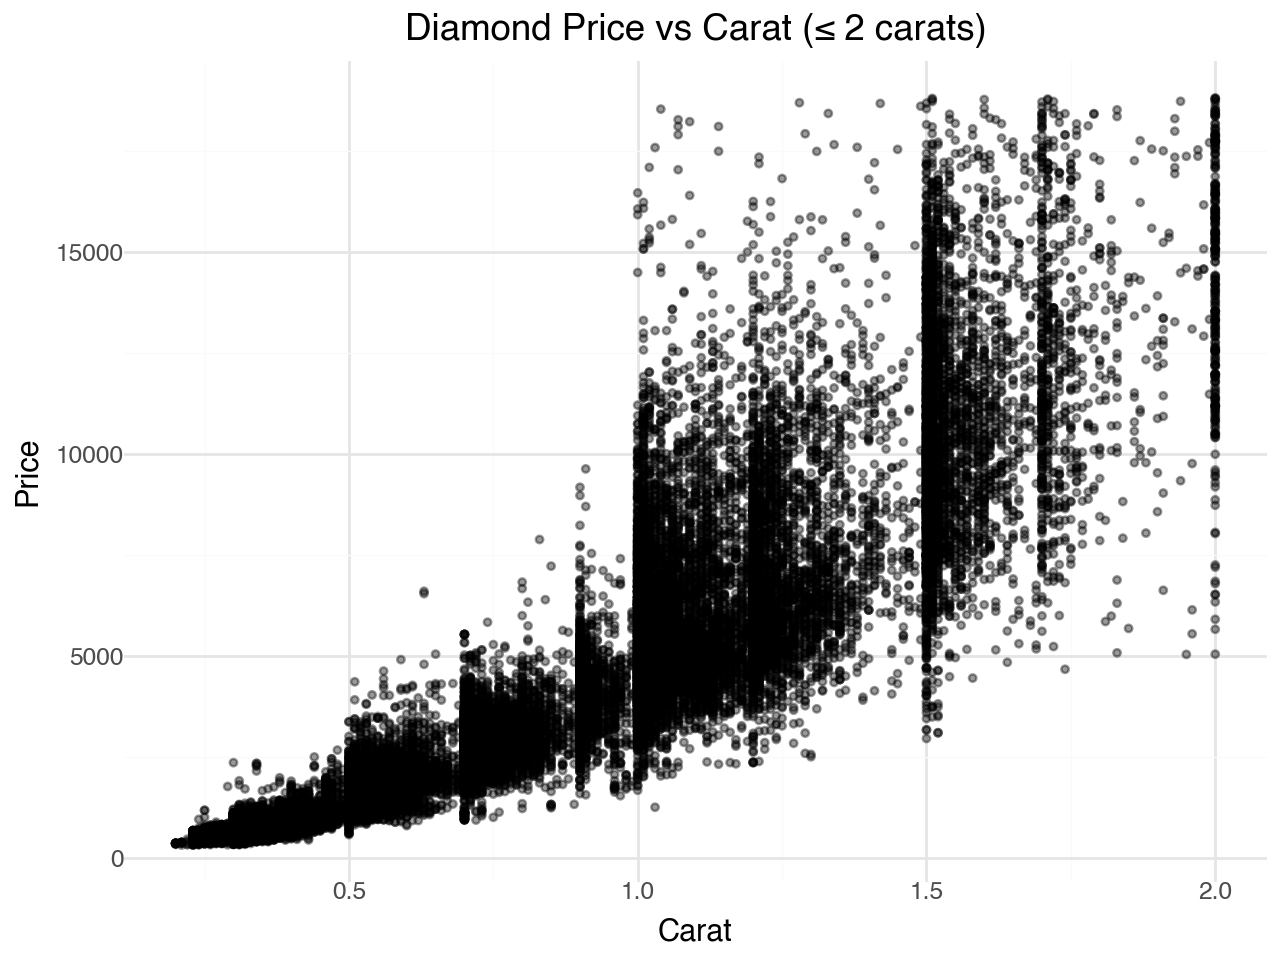

In [10]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

diamonds_subset = diamonds_shuffled[diamonds_shuffled['carat'] <= 2]

print("Rows before filtering:", diamonds_shuffled.shape[0])
n = diamonds_subset.shape[0]
print("Number of remaining rows:", n)

p = (
    ggplot(diamonds_subset, aes(x='carat', y='price')) +
    geom_point(alpha=0.4, size=1) +
    labs(title='Diamond Price vs Carat (≤ 2 carats)', x='Carat', y='Price') +
    theme_minimal()
)

p


Create a linear model of price ~ carat and gauge its in-sample performance using s_e.

In [16]:
import statsmodels.api as sm
import numpy as np

X = diamonds_subset['carat']
y = diamonds_subset['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

s_e = np.sqrt(model.scale)

print("Residual standard error (s_e):", s_e)


Residual standard error (s_e): 1451.9268767656401


Create a model of price ~ clarity and gauge its in-sample performance

In [18]:
diamonds_subset = diamonds_subset.copy()

diamonds_subset['clarity_numeric'] = diamonds_subset['clarity'].cat.codes

# Prepare independent variable (clarity_numeric with intercept)
X = sm.add_constant(diamonds_subset['clarity_numeric'])

# Dependent variable
y = diamonds_subset['price']

# Fit the model
model2 = sm.OLS(y, X).fit()

# Compute residual standard error
s_e = np.sqrt(model2.scale)

# Print the result
print("Residual standard error (s_e):", s_e)


Residual standard error (s_e): 3403.8252104875914


Why is the model price ~ carat substantially more accurate than price ~ clarity?

= The model price ~ carat is substantially more accurate than price ~ clarity because carat is a continuous numeric variable that has a strong and direct relationship with diamond price, whereas clarity is a categorical quality rating with a weaker, more indirect effect on price.


Create a new transformed feature ln_carat and plot it vs price.

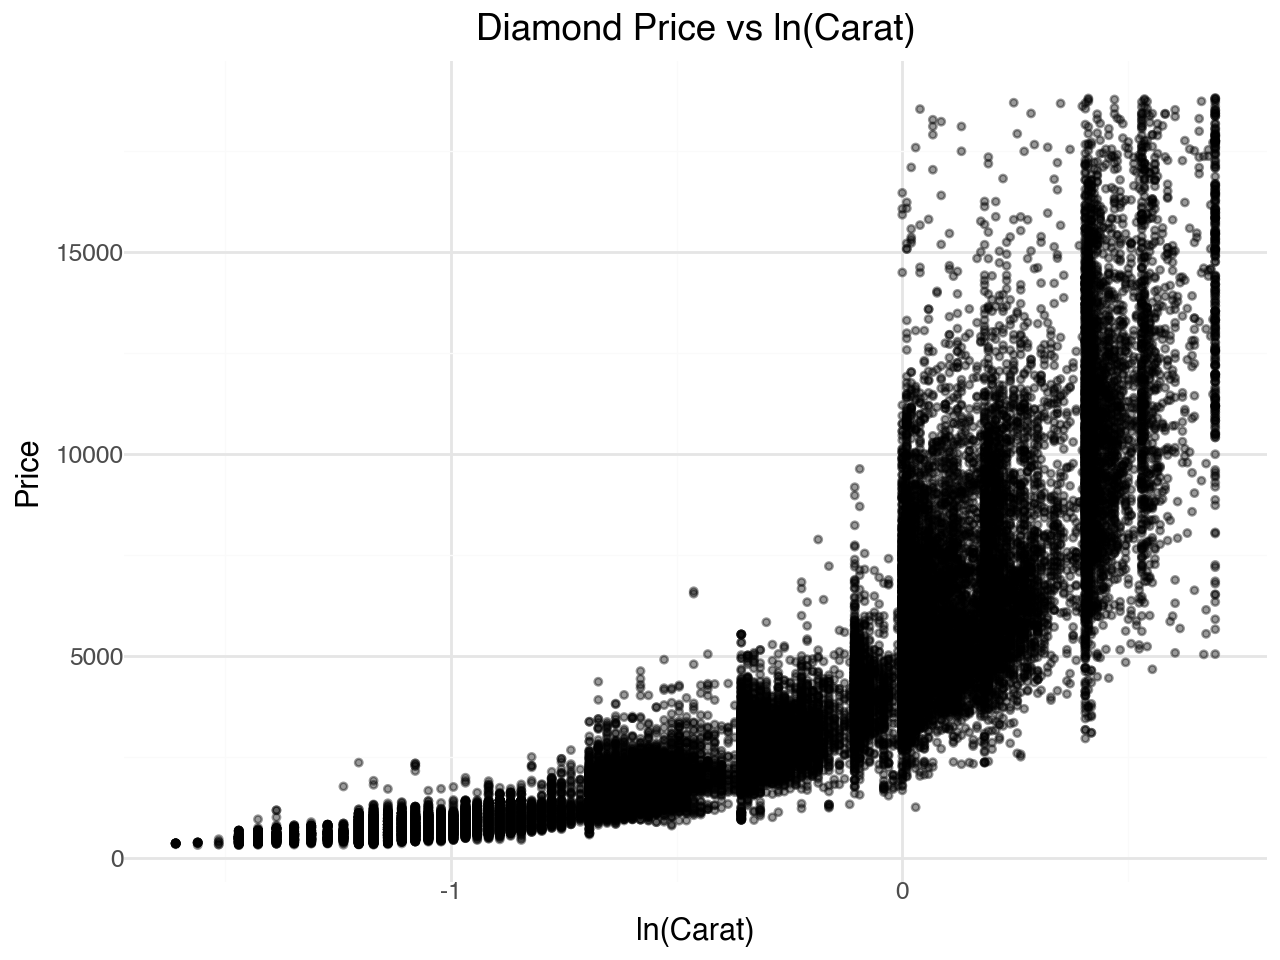

In [21]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

diamonds_ln_subset = diamonds_subset.copy()

diamonds_ln_subset['ln_carat'] = np.log(diamonds_ln_subset['carat'])

plot = (
    ggplot(diamonds_ln_subset, aes(x='ln_carat', y='price')) +
    geom_point(alpha=0.4, size=1) +
    labs(title='Diamond Price vs ln(Carat)', x='ln(Carat)', y='Price') +
    theme_minimal()
)

plot


Would price ~ ln_carat be a better fitting model than price ~ carat? Why or why not?

Yes, the relationship between carat and price is not linear — price increases more than proportionally with carat. A log transformation compresses large carat values and helps linearize the exponential price growth.

Verify this by comparing R^2 and RMSE of the two models:

In [25]:
X1 = sm.add_constant(diamonds_subset['carat'])
y = diamonds_subset['price']
model1 = sm.OLS(y, X1).fit()
r2_model1 = model1.rsquared
rmse_model1 = np.sqrt(model1.scale)


diamonds_subset['ln_carat'] = np.log(diamonds_subset['carat'])
X2 = sm.add_constant(diamonds_subset['ln_carat'])
model2 = sm.OLS(y, X2).fit()
r2_model2 = model2.rsquared
rmse_model2 = np.sqrt(model2.scale)

print("Model price ~ carat:")
print("  R² =", r2_model1)
print("  RMSE =", rmse_model1, "\n")

print("Model price ~ ln(carat):")
print("  R² =", r2_model2)
print("  RMSE =", rmse_model2)

Model price ~ carat:
  R² = 0.8192395330750623
  RMSE = 1451.9268767656401 

Model price ~ ln(carat):
  R² = 0.7122155914252806
  RMSE = 1832.0049719330857


Create a new transformed feature ln_price and plot its estimated density:

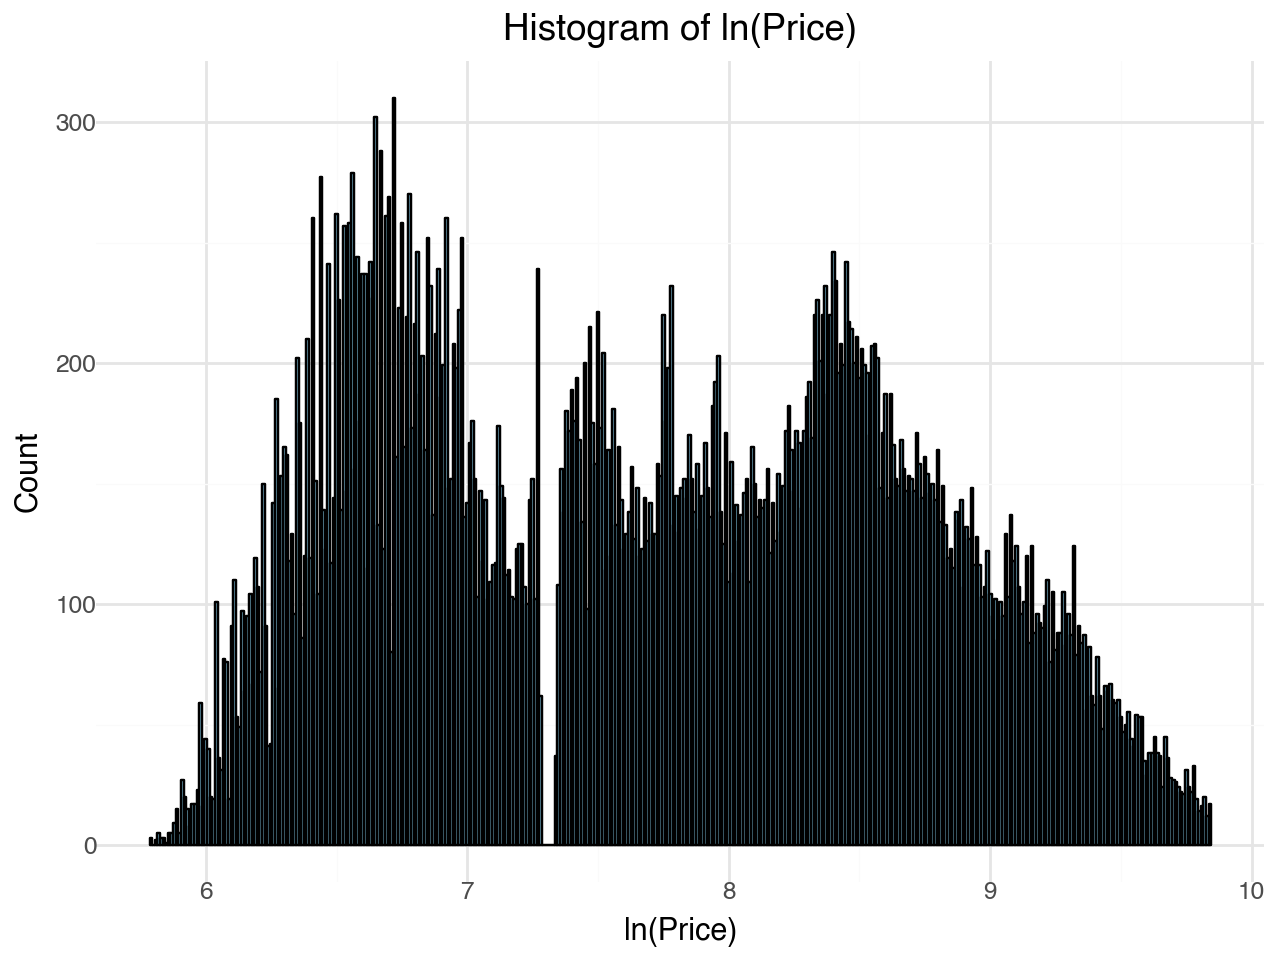

In [27]:
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal

# Create the ln_price feature
diamonds_subset['ln_price'] = np.log(diamonds_subset['price'])

# Plot the histogram
p = (
    ggplot(diamonds_subset, aes(x='ln_price')) +
    geom_histogram(binwidth=0.01, fill='skyblue', color='black') +
    labs(title='Histogram of ln(Price)', x='ln(Price)', y='Count') +
    theme_minimal()
)

p


Now plot it vs carat.

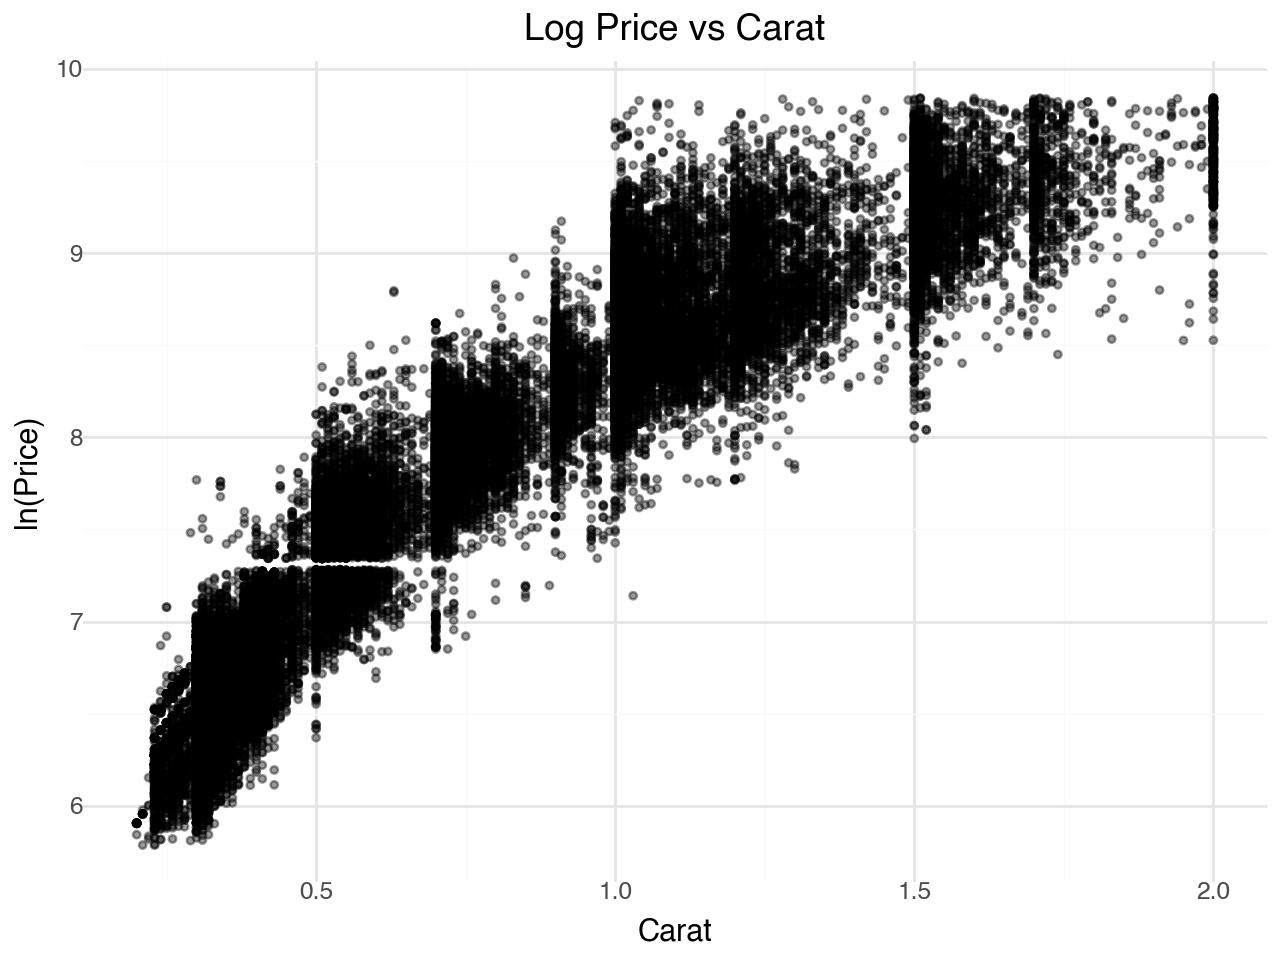

In [29]:
plot = (
    ggplot(diamonds_subset, aes(x='carat', y='ln_price')) +
    geom_point(alpha=0.4, size=1) +
    labs(title='Log Price vs Carat', x='Carat', y='ln(Price)') +
    theme_minimal()
)

plot


Would ln_price ~ carat be a better fitting model than price ~ carat? Why or why not?

Yes, ln_price ~ carat is often a better fitting model than price ~ carat because taking the logarithm of price helps to stabilize the variance, reduce skewness, and linearize the exponential relationship between price and carat, leading to a model that better satisfies the assumptions of linear regression and provides more accurate, interpretable results.

Verify this by computing s_e of this new model. Make sure these metrics can be compared apples-to-apples with the previous.

In [32]:
X_log = sm.add_constant(diamonds_subset['carat'])
y_log = np.log(diamonds_subset['price'])
model_log = sm.OLS(y_log, X_log).fit()

r2_log = model_log.rsquared
rmse_log = np.sqrt(model_log.scale)

pred_ln_price = model_log.predict(X_log)
pred_price = np.exp(pred_ln_price)

price = diamonds_subset['price']
resid_price = price - pred_price
rmse_orig = np.sqrt(np.mean(resid_price ** 2))

tss = np.sum((price - np.mean(price)) ** 2)
rss = np.sum((price - pred_price) ** 2)
r2_orig = 1 - (rss / tss)

print("Model ln(price) ~ carat (Log Scale):")
print("  R² (log scale)  =", r2_log)
print("  RMSE (log scale) =", rmse_log)

print("\nModel ln(price) ~ carat (Original Price Scale):")
print("  R² (original scale) =", r2_orig)
print("  RMSE (original scale) =", rmse_orig)

Model ln(price) ~ carat (Log Scale):
  R² (log scale)  = 0.8812677436334697
  RMSE (log scale) = 0.3345436751187939

Model ln(price) ~ carat (Original Price Scale):
  R² (original scale) = 0.36288653122122283
  RMSE (original scale) = 2725.794222598618


We just compared in-sample statistics to draw a conclusion on which model has better performance. But in-sample statistics can lie! Why is what we did valid?

What we did is valid in this case because we were comparing models that all used the same predictor variable (carat) and were applied to the same dataset. The only difference was the transformation of the response variable, from price to ln(price).


Plot ln_price vs ln_carat.

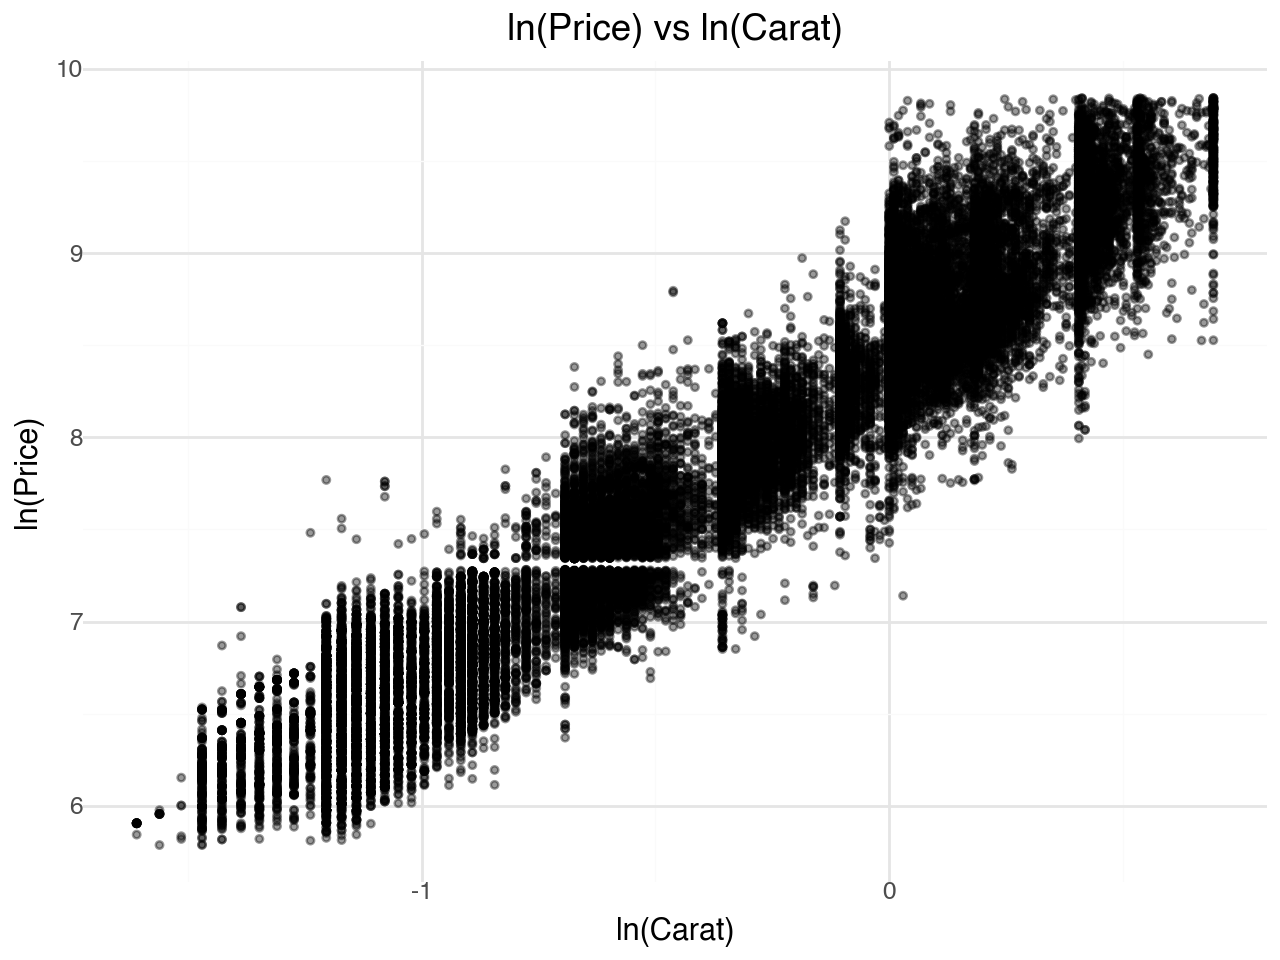

In [34]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal
import numpy as np

# Create transformed features (if not already present)
diamonds_subset['ln_price'] = np.log(diamonds_subset['price'])
diamonds_subset['ln_carat'] = np.log(diamonds_subset['carat'])

# Plot ln_price vs ln_carat
plot = (
    ggplot(diamonds_subset, aes(x='ln_carat', y='ln_price')) +
    geom_point(alpha=0.4, size=1) +
    labs(title='ln(Price) vs ln(Carat)', x='ln(Carat)', y='ln(Price)') +
    theme_minimal()
)

plot


Would ln_price ~ ln_carat be the best fitting model than the previous three we considered? Why or why not?

ln_price ~ ln_carat is likely the best fitting model because it captures the true shape of the relationship, meets regression assumptions better, and provides more interpretable results.

Verify this by computing s_e of this new model. Make sure these metrics can be compared apples-to-apples with the previous.

In [37]:
import statsmodels.api as sm
import numpy as np

# Prepare log-log variables
X_ln_ln = sm.add_constant(diamonds_subset['ln_carat'])
y_ln = diamonds_subset['ln_price']

# Fit the model ln(price) ~ ln(carat)
model_ln_ln = sm.OLS(y_ln, X_ln_ln).fit()

# A) Metrics on the log scale
s_e_log = np.sqrt(model_ln_ln.scale)
r2_log = model_ln_ln.rsquared

# B) Back-transform to price scale
pred_ln_price = model_ln_ln.predict(X_ln_ln)        # Predicted ln(price)
pred_price = np.exp(pred_ln_price)                  # Back-transformed to price

# Residuals on the original price scale
price_actual = diamonds_subset['price']
resids_price = price_actual - pred_price

# Residual standard error (RMSE) on original scale
s_e_price = np.sqrt(np.mean(resids_price ** 2))

# R² on original scale
tss = np.sum((price_actual - np.mean(price_actual)) ** 2)
rss = np.sum((resids_price) ** 2)
r2_price = 1 - rss / tss

# Print results
print("Model ln(price) ~ ln(carat):")
print(" -- On the log scale:")
print("    s_e (log scale) =", s_e_log)
print("    R^2 (log scale) =", r2_log, "\n")
print(" -- On the original scale:")
print("    s_e (price scale) =", s_e_price)
print("    R^2 (price scale) =", r2_price)


Model ln(price) ~ ln(carat):
 -- On the log scale:
    s_e (log scale) = 0.2613383067685494
    R^2 (log scale) = 0.9275448566575142 

 -- On the original scale:
    s_e (price scale) = 1396.6434892034083
    R^2 (price scale) = 0.8327362708448484


Compute b, the OLS slope coefficients for this new model of ln_price ~ ln_carat.

In [39]:
# Extract the slope coefficient (b) for ln_carat
b = model_ln_ln.params['ln_carat']
b

1.6965895413165994

Interpret b_1, the estimated slope of ln_carat.

The slope b1 tells us how price changes with carat on a percentage scale.
For example, if b1 = 1.69, then a 1% increase in carat is associated with approximately a 1.69% increase in price.

Interpret b_0, the estimated intercept.

The intercept b0 is the predicted value of ln(price) when ln(carat) = 0.
Since ln(1) = 0, this means b0 is the ln(price) for a 1-carat diamond.

Create other features ln_x, ln_y, ln_z, ln_depth, ln_table.

In [41]:
# Create new log-transformed features
epsilon = 1e-6  # small value to avoid log(0)

diamonds_ln_subset['ln_x'] = np.log(diamonds_ln_subset['x'] + epsilon)
diamonds_ln_subset['ln_y'] = np.log(diamonds_ln_subset['y'] + epsilon)
diamonds_ln_subset['ln_z'] = np.log(diamonds_ln_subset['z'] + epsilon)
diamonds_ln_subset['ln_depth'] = np.log(diamonds_ln_subset['depth'] + epsilon)
diamonds_ln_subset['ln_table'] = np.log(diamonds_ln_subset['table'] + epsilon)

# Optionally display the first few rows
print(diamonds_ln_subset.head())


   carat        cut color clarity  depth  table  price     x     y     z  \
0   0.24      Ideal     G    VVS1   62.1   56.0    559  3.97  4.00  2.47   
1   0.58  Very Good     F    VVS2   60.0   57.0   2201  5.44  5.42  3.26   
2   0.40      Ideal     E    VVS2   62.1   55.0   1238  4.76  4.74  2.95   
3   0.43    Premium     E    VVS2   60.8   57.0   1304  4.92  4.89  2.98   
4   1.55      Ideal     E     SI2   62.3   55.0   6901  7.44  7.37  4.61   

   clarity_numeric  ln_carat      ln_x      ln_y      ln_z  ln_depth  ln_table  
0                6 -1.427116  1.378766  1.386295  0.904219  4.128746  4.025352  
1                5 -0.544727  1.693779  1.690096  1.181728  4.094345  4.043051  
2                5 -0.916291  1.560248  1.556037  1.081806  4.128746  4.007333  
3                5 -0.843970  1.593309  1.587193  1.091924  4.107590  4.043051  
4                1  0.438255  2.006871  1.997418  1.528228  4.131961  4.007333  


From now on, we will be modeling ln_price (not raw price) as the prediction target. 

Create a model (B) of ln_price on ln_carat interacted with clarity and compare its performance with the model (A) ln_price ~ ln_carat.

In [47]:
import numpy as np
import statsmodels.formula.api as smf

# Ensure ln_price and ln_carat exist
diamonds_ln_subset['ln_price'] = np.log(diamonds_ln_subset['price'])
diamonds_ln_subset['ln_carat'] = np.log(diamonds_ln_subset['carat'])

# Model A: ln_price ~ ln_carat
model_A = smf.ols('ln_price ~ ln_carat', data=diamonds_ln_subset).fit()
r2_A = model_A.rsquared
rmse_A = np.sqrt(np.mean(model_A.resid**2))

# Model B: ln_price ~ ln_carat * clarity
model_B = smf.ols('ln_price ~ ln_carat * clarity', data=diamonds_ln_subset).fit()
r2_B = model_B.rsquared
rmse_B = np.sqrt(np.mean(model_B.resid**2))

# Print comparison
print("Model A: ln_price ~ ln_carat")
print("  R² =", r2_A)
print("  RMSE =", rmse_A)
print("")
print("Model B: ln_price ~ ln_carat * clarity")
print("  R² =", r2_B)
print("  RMSE =", rmse_B)


Model A: ln_price ~ ln_carat
  R² = 0.9275448566575142
  RMSE = 0.26133328590790844

Model B: ln_price ~ ln_carat * clarity
  R² = 0.9630831364903961
  RMSE = 0.1865402339481072


Which model does better? Why?

Model B does better because it accounts for how the effect of carat on price changes with clarity, leading to a more accurate and nuanced model.

Create a model of (C) ln_price on ln_carat interacted with every categorical feature (clarity, cut and color) and compare its performance with model (B)

In [49]:
# Model C: ln_price ~ ln_carat interacted with clarity, cut, and color
model_C = smf.ols(
    'ln_price ~ ln_carat * clarity + ln_carat * cut + ln_carat * color',
    data=diamonds_ln_subset
).fit()

# Compute R² and RMSE
r2_C = model_C.rsquared
rmse_C = np.sqrt(np.mean(model_C.resid ** 2))

# Print results
print("Model C (ln_price ~ ln_carat * clarity + ln_carat * cut + ln_carat * color):")
print("  R² =", r2_C)
print("  RMSE =", rmse_C)


Model C (ln_price ~ ln_carat * clarity + ln_carat * cut + ln_carat * color):
  R² = 0.9820592739553672
  RMSE = 0.1300409478785979


Which model does better? Why?

Model C does better than Model B in terms of in-sample performance, because it includes more interactions, allowing it to capture more complex relationships between carat and all three categorical features: clarity, cut, and color.

Create a model (D) of ln_price on every continuous feature (logs of carat, x, y, z, depth, table) interacted with every categorical feature (clarity, cut and color) and compare its performance with model (C).

In [52]:
formula_D = (
    'ln_price ~ (ln_carat + ln_x + ln_y + ln_z + ln_depth + ln_table) * '
    '(clarity + cut + color)'
)

# Fit model
model_D = smf.ols(formula_D, data=diamonds_ln_subset).fit()

# Calculate R² and RMSE
r2_D = model_D.rsquared
rmse_D = np.sqrt(np.mean(model_D.resid ** 2))

# Print results
print("Model D (ln_price ~ (all continuous logs) * (clarity + cut + color)):")
print("  R² =", r2_D)
print("  RMSE =", rmse_D)


Model D (ln_price ~ (all continuous logs) * (clarity + cut + color)):
  R² = 0.9828630904899284
  RMSE = 0.127094387034855


Which model does better? Why?

Model D performs better than Model C in terms of in-sample performance because it includes more information and more complex interactions.



What is the p of this model D? Compute with code.

In [54]:
# Compute number of parameters (including intercept)
p = len(model_D.params)
print("The number of parameters (p) in Model D is:", p)

The number of parameters (p) in Model D is: 126


Create model (E) which is the same as before except create include the raw features interacted with the categorical features and gauge the performance against (D).

In [56]:
# Model E: Use raw features instead of log-transformed ones
formula_E = (
    'ln_price ~ (carat + x + y + z + depth + table) * '
    '(clarity + cut + color)'
)

# Fit the model
model_E = smf.ols(formula_E, data=diamonds_ln_subset).fit()

# Compute R² and RMSE
r2_E = model_E.rsquared
rmse_E = np.sqrt(np.mean(model_E.resid ** 2))

# Print the results
print("Model E (using raw continuous features):")
print("  R² =", r2_E)
print("  RMSE =", rmse_E)


Model E (using raw continuous features):
  R² = 0.9775956880117719
  RMSE = 0.1453201793000741


Which model does better? Why?

Model D outperforms Model E because log-transformed features better capture the underlying structure of the data, improve regression assumptions, and lead to a more accurate and stable model.

Create model (F) which is the same as before except also include also third degree polynomials of the continuous features interacted with the categorical features and gauge performance against (E). 

In [61]:
# Model F: third-degree polynomials of raw continuous features interacted with categorical features
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "             (x + I(x**2) + I(x**3)) + "
    "             (y + I(y**2) + I(y**3)) + "
    "             (z + I(z**2) + I(z**3)) + "
    "             (depth + I(depth**2) + I(depth**3)) + "
    "             (table + I(table**2) + I(table**3))) * "
    "(clarity + cut + color)"
)

# Fit the model
model_F = smf.ols(formula_F, data=diamonds_ln_subset).fit()

# Compute R² and RMSE
r2_F = model_F.rsquared
rmse_F = np.sqrt(np.mean(model_F.resid ** 2))

# Print results
print("Model F (3rd degree polynomials of continuous features):")
print("  R² =", r2_F)
print("  RMSE =", rmse_F)


Model F (3rd degree polynomials of continuous features):
  R² = 0.987577796308232
  RMSE = 0.10820801799248309


Which model does better? Why?

Model F outperforms Model E in-sample due to its ability to model complex nonlinear relationships and interactions, but its complexity also makes it more prone to overfitting.

Can you think of any other way to expand the candidate set curlyH? Discuss.

We should probably assess oos performance now. Sample 2,000 diamonds and use these to create a training set of 1,800 random diamonds and a test set of 200 random diamonds. Define K and do this splitting:

In [66]:
np.random.seed(123) 
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n=K, random_state=123).reset_index(drop=True)

# Randomly select 1,800 indices for training
train_indices = np.random.choice(K, size=1800, replace=False)

# Create training and test sets
train_set = diamonds_sample.iloc[train_indices]
test_set = diamonds_sample.drop(train_indices).reset_index(drop=True)

# Verify sizes
print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])


Training set size: 1800
Test set size: 200


Compute in and out of sample performance for models A-F. Use s_e as the metric (standard error of the residuals). Create a list with keys A, B, ..., F to store these metrics. Remember the performances here will be worse than before since before you're using nearly 52,000 diamonds to build a model and now it's only 1,800! 

In [70]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

formulas = {
    'A': "ln_price ~ ln_carat",
    'B': "ln_price ~ ln_carat * C(clarity)",
    'C': "ln_price ~ ln_carat * (C(clarity) + C(cut) + C(color))",
    'D': "ln_price ~ (ln_carat + ln_x + ln_y + ln_z + ln_depth + ln_table) * (C(clarity) + C(cut) + C(color))",
    'E': "ln_price ~ (carat + x + y + z + depth + table) * (C(clarity) + C(cut) + C(color))",
    'F': "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
         "(x + I(x**2) + I(x**3)) + (y + I(y**2) + I(y**3)) + "
         "(z + I(z**2) + I(z**3)) + (depth + I(depth**2) + I(depth**3)) + "
         "(table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
}

performance = {}

for key, formula in formulas.items():
    model = smf.ols(formula, data=train_set).fit()

    # In-sample s_e
    pred_train = model.predict(train_set)
    s_e_in = np.sqrt(np.mean((train_set['ln_price'] - pred_train) ** 2))

    # Out-of-sample s_e
    pred_test = model.predict(test_set)
    s_e_out = np.sqrt(np.mean((test_set['ln_price'] - pred_test) ** 2))

    # Store results
    performance[key] = {'in_sample': s_e_in, 'out_sample': s_e_out}

# Convert to DataFrame
performance_table = pd.DataFrame.from_dict(performance, orient='index')
performance_table.index.name = 'Model'
print(performance_table)


       in_sample  out_sample
Model                       
A       0.258264    0.265014
B       0.186482    0.187401
C       0.131140    0.131148
D       0.122881    0.141666
E       0.120898    0.136722
F       0.093838    0.132262


You computed oos metrics only on n_* = 200 diamonds. What problem(s) do you expect in these oos metrics?

Using only 200 diamonds to compute out-of-sample metrics can lead to several issues. First, the estimates of model performance will have high variance because the test set is small. This means the results are sensitive to the specific random sample of diamonds chosen, and small changes in the test set could lead to noticeably different results. 

To do the K-fold cross validation we need to get the splits right and crossing is hard. We've developed code for this already in a previous lab.

In [72]:
import numpy as np
from sklearn.model_selection import KFold

# Total number of observations
n = diamonds_ln_subset.shape[0]  # or use a sampled subset if you'd like

# Number of folds
K = 5  # You can set to 10 if preferred

# Create KFold object
kf = KFold(n_splits=K, shuffle=True, random_state=123)

# Create an array to store fold assignments
folds_vec = np.empty(n, dtype=int)

# Loop over splits and assign fold numbers
for fold, (_, test_index) in enumerate(kf.split(np.arange(n)), start=1):
    folds_vec[test_index] = fold

# Print the first 200 fold assignments
print(folds_vec[:200])


[5 1 4 3 5 2 4 4 1 3 4 4 3 5 3 1 4 5 4 1 2 3 5 1 4 4 1 1 4 1 2 2 2 4 4 5 5
 5 3 1 2 5 4 2 4 4 1 5 4 2 4 1 1 1 2 5 4 2 4 5 5 3 1 4 2 3 3 2 4 5 5 5 3 5
 3 4 3 1 5 4 4 1 5 5 2 3 1 2 4 4 2 2 3 3 1 2 5 4 5 5 1 3 3 3 2 4 3 4 5 5 4
 5 3 3 3 1 3 3 1 4 2 2 5 1 3 1 5 5 2 4 2 5 1 2 2 4 1 1 5 3 5 1 1 4 2 2 2 2
 2 3 4 5 2 1 1 1 4 5 5 1 3 4 4 3 5 4 4 4 4 5 5 1 5 4 2 5 2 5 3 2 4 5 1 5 2
 4 1 1 5 5 1 5 2 2 5 2 5 3 5 3]


Do the K-fold cross validation for model F and compute the overall s_e and s_s_e. 

In [74]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

np.random.seed(123)

# Sample 2,000 diamonds from the full dataset
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n=K, random_state=123).reset_index(drop=True)

# Split into training and test sets
train_indices = np.random.choice(K, size=1800, replace=False)
train_set = diamonds_sample.iloc[train_indices]
test_set = diamonds_sample.drop(train_indices).reset_index(drop=True)

print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Define Model F formula
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "(x + I(x**2) + I(x**3)) + "
    "(y + I(y**2) + I(y**3)) + "
    "(z + I(z**2) + I(z**3)) + "
    "(depth + I(depth**2) + I(depth**3)) + "
    "(table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
)

fold_rmse = []
total_SSE = 0
total_n = 0

# K-fold cross-validation loop
for train_idx, val_idx in kf.split(train_set):
    train_fold = train_set.iloc[train_idx]
    val_fold = train_set.iloc[val_idx]
    
    model_F_cv = smf.ols(formula_F, data=train_fold).fit()
    pred = model_F_cv.predict(val_fold)
    resid = val_fold['ln_price'] - pred
    s_e_fold = np.sqrt(np.mean(resid ** 2))
    fold_rmse.append(s_e_fold)
    
    total_SSE += np.sum(resid ** 2)
    total_n += len(val_fold)

# Overall cross-validated s_e and its standard deviation
overall_s_e = np.sqrt(total_SSE / total_n)
s_s_e = np.std


Training set size: 1800
Test set size: 200


Does K-fold CV help reduce variance in the oos s_e? Discuss.

= Yes, K-fold cross-validation helps reduce the variance in the out-of-sample standard error (sₑ). When we evaluate a model’s performance using a single random test set, the estimate of sₑ can vary a lot depending on which specific observations happen to be in that test set.

K-fold cross validation helps reduce the variance in the out-of-sample sₑ estimate because it averages performance over multiple different splits of the training data. Instead of relying on one arbitrary partition of data, K-fold CV trains and evaluates the model K times on different subsets, which smooths out the influence of any one particularly “easy” or “hard” split. However, while this approach reduces variance compared to a single train–test split, some variability may still remain, especially if the overall sample size is small.

Imagine using the entire rest of the dataset besides the 2,000 training observations divvied up into slices of 200. Measure the oos error for each slice on Model F in a vector `s_e_s_F` and compute the `s_s_e_F` and also plot it.

In [78]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, scale_x_log10

np.random.seed(123)

# Sample K = 2000 diamonds (keep original index!)
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n=K, random_state=123)

# Randomly select 1,800 for training, rest for test
train_indices = np.random.choice(diamonds_sample.index, size=1800, replace=False)
train_set = diamonds_sample.loc[train_indices].reset_index(drop=True)
test_set = diamonds_sample.drop(train_indices).reset_index(drop=True)

print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

# Define the rest of the data not in the 2,000 sampled diamonds
rest_set = diamonds_ln_subset.drop(diamonds_sample.index).reset_index(drop=True)

# Split into full slices of 200
num_slices = len(rest_set) // 200
rest_set_subset = rest_set.iloc[:num_slices * 200]
slices = np.array_split(rest_set_subset, num_slices)

# Fit Model F on the training set
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "(x + I(x**2) + I(x**3)) + "
    "(y + I(y**2) + I(y**3)) + "
    "(z + I(z**2) + I(z**3)) + "
    "(depth + I(depth**2) + I(depth**3)) + "
    "(table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
)
model_F_final = smf.ols(formula_F, data=train_set).fit()

# Compute out-of-sample RMSE on each slice
s_e_s_F = []
for slice_df in slices:
    pred = model_F_final.predict(slice_df)
    resid = slice_df['ln_price'] - pred
    rmse = np.sqrt(np.mean(resid ** 2))
    s_e_s_F.append(rmse)

s_e_s_F = np.array(s_e_s_F)
s_s_e_F = np.std(s_e_s_F, ddof=1)

print("s_e_s_F (RMSE for each slice):", s_e_s_F)
print("s_s_e_F (Standard deviation of slice RMSE):", s_s_e_F)

Training set size: 1800
Test set size: 200


/Applications/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


s_e_s_F (RMSE for each slice): [3.25238436e-01 1.38430236e-01 6.27509639e-01 1.94382281e-01
 5.50666201e-01 1.67650161e-01 1.56155419e-01 1.87367005e-01
 1.54121073e-01 1.74395086e-01 1.02942831e+00 1.42066033e-01
 1.64958149e-01 1.98065600e-01 3.50768063e-01 1.54125679e-01
 2.99954183e-01 8.96503960e-01 6.83547864e-01 2.43658040e+00
 1.36155687e-01 2.07151772e+00 1.49184309e-01 6.69610067e-01
 8.54779680e-01 1.37188703e-01 1.26009839e-01 1.38892884e+00
 1.16022093e+00 1.35855757e-01 1.80365488e-01 1.57299901e-01
 3.38579333e-01 1.22805020e-01 1.37426650e-01 1.69478775e-01
 1.18196139e-01 2.53608153e-01 1.72433310e-01 1.49478132e-01
 1.15265795e+00 2.50926073e-01 8.29929224e-01 2.25897701e-01
 1.90030436e-01 1.64367271e-01 1.38779012e-01 3.11357040e-01
 1.49396985e-01 4.18686191e-01 1.90231432e-01 4.17120118e-01
 3.12528648e-01 4.91955880e-01 1.18064245e-01 3.44250454e-01
 1.13626832e-01 2.87803882e-01 2.20501668e-01 1.74794667e-01
 1.26540656e+00 2.63007738e+02 1.57670799e-01 2.407206

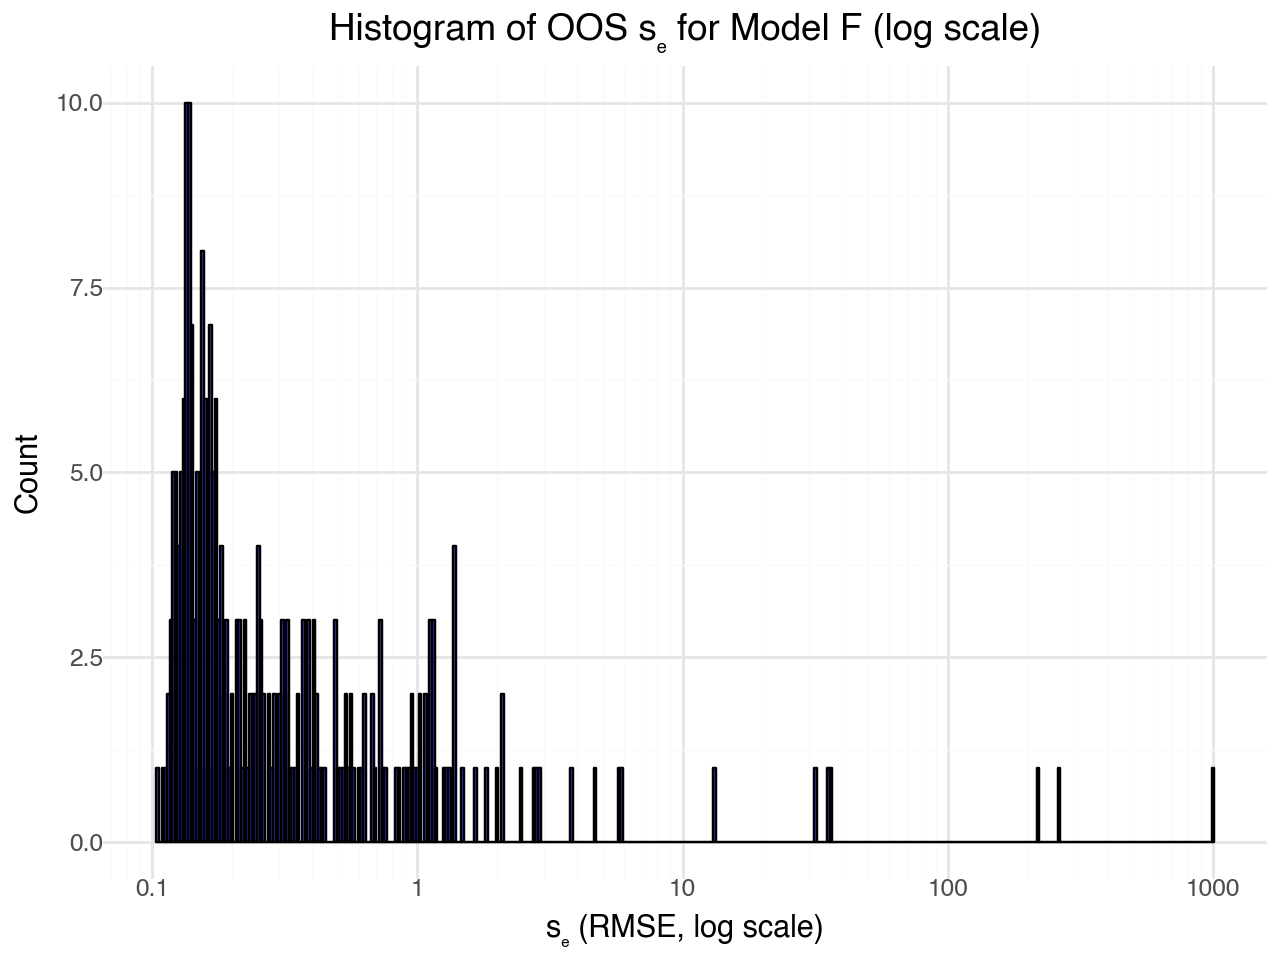

In [80]:
df_plot = pd.DataFrame({'s_e_s_F': s_e_s_F})

p = (
    ggplot(df_plot, aes(x='s_e_s_F')) +
    geom_histogram(binwidth=0.01, fill="blue", color="black", alpha=0.7) +
    labs(
        title="Histogram of OOS sₑ for Model F (log scale)",
        x="sₑ (RMSE, log scale)",
        y="Count"
    ) +
    scale_x_log10() +
    theme_minimal()
)

p

#Rcpp and optimizing R

Write a function `dot_product_py` in python that takes in two vectors `v1` and `v2` and returns their dot product.

In [82]:
def dot_product_py(v1, v2):
    return sum(x * y for x, y in zip(v1, v2))

# Example usage:
v1 = [1, 2, 3, 4]
v2 = [5, 6, 7, 8]
print(dot_product_py(v1, v2))  # Output should be 70

v1 = [1, 2, 3]
v2 = [4, 5, 6]
print(dot_product_py(v1, v2))  # Output: 1*4 + 2*5 + 3*6 = 32



70
32


Write a function `dot_product_cpp` in C++ and make sure it compiles. First uncomment the cell below and install cython

In [84]:
!pip install cython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.8 MB/s eta 0:00:00a 0:00:01


In [85]:
%load_ext Cython

In [98]:
%%cython

import numpy as np
cimport numpy as np

def dot_product_cython(np.ndarray[np.double_t, ndim=1] v1, np.ndarray[np.double_t, ndim=1] v2):
    cdef Py_ssize_t n = v1.shape[0]
    if v2.shape[0] != n:
        raise ValueError("Vectors must have the same length")

    cdef Py_ssize_t i
    cdef double result = 0.0
    for i in range(n):
        result += v1[i] * v2[i]
    return result


Content of stderr:
In file included from /Users/faritakhan/.cache/ipython/cython/_cython_magic_d4ee3f3cfab5eae457ec459ad6ac24c94685de53.c:1252:
In file included from /Applications/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Applications/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Applications/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Applications/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^
/Users/faritakhan/.cache/ipython/cython/_cython_magic_d4ee3f3cfab5eae457ec459ad6ac24c94685de53.c:6761:26: warning: code will never be executed [-Wunreachable-code]
 6761 |          

In [100]:
import numpy as np

v1 = np.array([1.0, 2.0, 3.0], dtype=np.float64)
v2 = np.array([4.0, 5.0, 6.0], dtype=np.float64)

result = dot_product_cython(v1, v2)
print("Dot product (Cython):", result)  # Expected output: 32.0


Dot product (Cython): 32.0


Create two vectors of standard normal realizations with length `n=1e6` and test the different in speed.

In [103]:
import numpy as np
import timeit

# Create vectors of length 1,000,000
n = int(1e6)
v1 = np.random.randn(n)
v2 = np.random.randn(n)

# Time the Python version
def dot_product_py(v1, v2):
    return sum(x * y for x, y in zip(v1, v2))

# Time the Cython version
print("Timing Python implementation:")
%timeit dot_product_py(v1, v2)

print("\nTiming Cython implementation:")
%timeit dot_product_cython(v1, v2)


Timing Python implementation:
358 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing Cython implementation:
1.95 ms ± 88.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Implement the Gram Schmidt routine as a C++ function `gram_schmidt_cython`.

In [115]:
%load_ext cython
%%cython --cplus


The cython extension is already loaded. To reload it, use:
  %reload_ext cython


UsageError: Line magic function `%%cython` not found.


In [117]:
%load_ext cython

%%cython --cplus
# distutils: language = c++
# cython: language_level=3

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def gram_schmidt_cython(np.ndarray[np.double_t, ndim=2] A):
    """
    Perform classical Gram-Schmidt orthonormalization on the columns of matrix A.
    Returns an orthonormal matrix Q with the same shape as A.
    """
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int i, j, k
    cdef double norm_val, dot_val
    cdef np.ndarray[np.double_t, ndim=2] Q = np.empty((m, n), dtype=np.double)

    # Copy A into Q
    for j in range(n):
        for i in range(m):
            Q[i, j] = A[i, j]

    # Gram-Schmidt orthonormalization
    for j in range(n):
        # Normalize column j
        norm_val = 0.0
        for i in range(m):
            norm_val += Q[i, j] * Q[i, j]
        norm_val = norm_val ** 0.5
        if norm_val == 0.0:
            raise ValueError("Zero column encountered in input matrix")
        for i in range(m):
            Q[i, j] /= norm_val
        # Subtract projection from subsequent columns
        for k in range(j + 1, n):
            dot_val = 0.0
            for i in range(m):
                dot_val += Q[i, j] * Q[i, k]
            for i in range(m):
                Q[i, k] -= dot_val * Q[i, j]

    return Q



SyntaxError: invalid syntax (2241739816.py, line 8)

Here is the implementation in taken from lab 5:

In [120]:
import numpy as np

def gram_schmidt_R(X):
    """
    Perform classical Gram-Schmidt orthonormalization on the columns of matrix X.
    
    Parameters
    ----------
    X : numpy.ndarray, shape (m, n)
        Input matrix whose columns will be orthonormalized.
    
    Returns
    -------
    Q : numpy.ndarray, shape (m, n)
        Orthonormal matrix whose columns are the orthonormalized version of X's columns.
    """
    m, n = X.shape
    # Create an empty matrix to store the orthogonalized vectors
    V = np.empty((m, n), dtype=X.dtype)
    # Set the first column of V as the first column of X
    V[:, 0] = X[:, 0]
    
    # For each subsequent column j
    for j in range(1, n):
        # Start with the j-th column of X
        V[:, j] = X[:, j]
        # Subtract the projection of X[:, j] on each previously computed v_k
        for k in range(j):
            v_k = V[:, k]
            # Compute the projection coefficient: (v_k^T X[:, j])/(||v_k||^2)
            proj_coeff = np.dot(v_k, X[:, j]) / np.sum(v_k**2)
            # Subtract the projection
            V[:, j] -= proj_coeff * v_k
    
    # Normalize each column of V to obtain Q
    Q = np.empty((m, n), dtype=X.dtype)
    for j in range(n):
        norm = np.sqrt(np.sum(V[:, j]**2))
        Q[:, j] = V[:, j] / norm
    
    return Q


# Example ... Create a random 5x3 matrix
X = np.random.randn(5, 3)
Q = gram_schmidt_R(X)
print("Input matrix X:")
print(X)
print("\nOrthonormal matrix Q:")
print(Q)
# Verify orthonormality: Q^T Q should be close to the identity matrix.
print("\nQ^T Q:")
print(np.dot(Q.T, Q))

Input matrix X:
[[-0.9264983   1.38491194  0.01192047]
 [ 0.44690308  0.75885068 -0.19271358]
 [-0.15848126 -0.35287665  0.03399763]
 [ 0.9830204  -2.09996522 -1.184948  ]
 [-0.46304994 -0.72610058  0.67877211]]

Orthonormal matrix Q:
[[-0.61575526  0.14763054 -0.71322061]
 [ 0.29701395  0.59901988  0.12557088]
 [-0.10532741 -0.25177455 -0.08243328]
 [ 0.65332012 -0.45282588 -0.55144332]
 [-0.30774524 -0.5924008   0.4057873 ]]

Q^T Q:
[[1.00000000e+00 2.93109821e-17 3.51883517e-16]
 [2.93109821e-17 1.00000000e+00 7.33528128e-18]
 [3.51883517e-16 7.33528128e-18 1.00000000e+00]]


Now let's see how much faster C++ is by running it on the boston housing data design matrix

In [123]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import timeit

# ------------------------------
# Step 1: Load and process the Boston housing data
# ------------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

# Combine the two halves: even rows are predictors, odd rows give response and extra columns
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
col_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
             "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
df = pd.DataFrame(np.hstack([data, target.reshape(-1, 1)]), columns=col_names)
df = df.astype(float)

# ------------------------------
# Step 2: Create design matrix without patsy (using statsmodels)
# ------------------------------
X = df.drop("MEDV", axis=1)
X = sm.add_constant(X)
y = df["MEDV"]

# For benchmarking, convert X to a NumPy array
X_np = np.asarray(X)

# ------------------------------
# Step 4: Assume gram_schmidt_cython is already compiled (fallback to pure Python if not)
# ------------------------------
try:
    gram_schmidt_cython
except NameError:
    print("Warning: gram_schmidt_cython is not defined; using pure Python version instead.")
    gram_schmidt_cython = gram_schmidt_R

# ------------------------------
# Step 5: Benchmark both implementations using timeit (10 runs each)
# ------------------------------
py_time = timeit.timeit(lambda: gram_schmidt_R(X_np), number=10)
cy_time = timeit.timeit(lambda: gram_schmidt_cython(X_np), number=10)

print("Pure Python Gram-Schmidt time over 10 runs:", py_time)
print("Cython Gram-Schmidt time over 10 runs:", cy_time)

Pure Python Gram-Schmidt time over 10 runs: 0.020675893996667583
Cython Gram-Schmidt time over 10 runs: 0.02173442400089698


Extra Credit (+5): Create a variable `n` to be 10 and a vaiable `Nvec` to be 100 initially. Create a random vector via `np.random.randn` `Nvec` times and load it into a `Nvec` x `n` dimensional matrix.

In [125]:
import numpy as np

# Part 1: Create random matrix
n = 10
Nvec = 100
np.random.seed(123)

# Each row is a random vector of length n
X = np.random.randn(Nvec, n)
print("Matrix shape:", X.shape)


Matrix shape: (100, 10)


Extra Credit (+5): Write a function `all_angles` that measures the angle between each of the pairs of vectors. You should measure the vector on a scale of 0 to 180 degrees with negative angles coerced to be positive. Then plot the density of these angles.

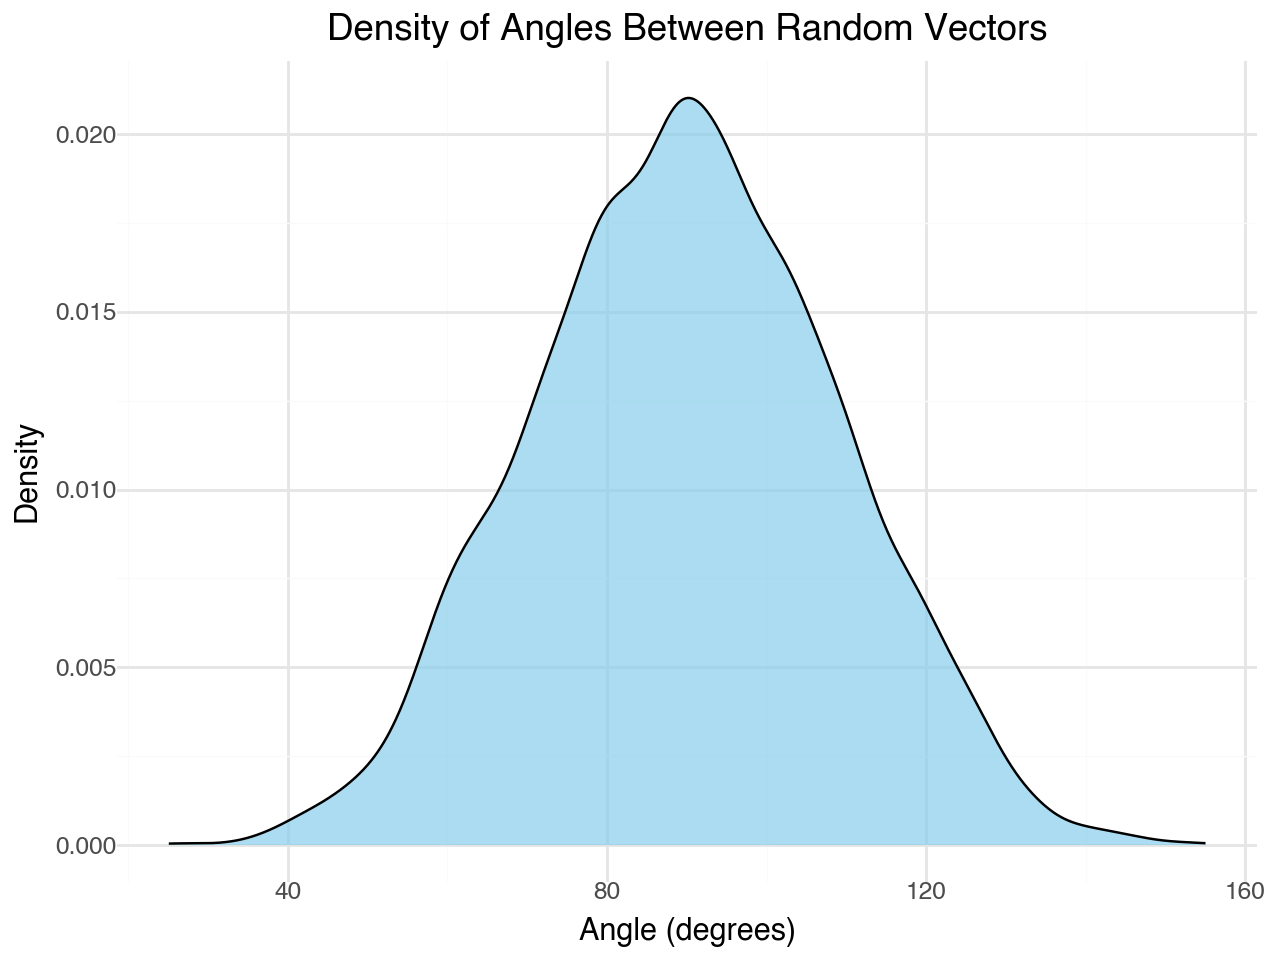

In [129]:
def all_angles(X):
    """
    Compute angles (in degrees) between all unique pairs of vectors (rows of X).
    Returns a list of angles in [0, 180].
    """
    N = X.shape[0]
    angles = []

    for i in range(N):
        for j in range(i + 1, N):
            u = X[i]
            v = X[j]
            dot = np.dot(u, v)
            norm_u = np.linalg.norm(u)
            norm_v = np.linalg.norm(v)
            cos_theta = dot / (norm_u * norm_v)
            cos_theta = np.clip(cos_theta, -1.0, 1.0)  # avoid domain error
            theta_rad = np.arccos(cos_theta)
            theta_deg = np.degrees(theta_rad)
            angles.append(theta_deg)

    return np.array(angles)

from plotnine import ggplot, aes, geom_density, labs, theme_minimal

# Compute all pairwise angles
angle_values = all_angles(X)

# Plot the density
df_angles = pd.DataFrame({'Angle (degrees)': angle_values})

plot = (
    ggplot(df_angles, aes(x='Angle (degrees)')) +
    geom_density(fill='skyblue', alpha=0.7) +
    labs(title='Density of Angles Between Random Vectors',
         x='Angle (degrees)', y='Density') +
    theme_minimal()
)
plot


Write an Rcpp function `all_angles_cpp` that does the same thing. Use an IDE if you want, but write it below in-line.

In [141]:
# Load Rcpp
library(Rcpp)

# Define the all_angles_cpp function
cppFunction('
NumericMatrix all_angles_cpp(NumericMatrix X) {
  int n = X.nrow();
  int m = X.ncol();
  NumericMatrix angle_matrix(n, n);
  
  for (int i = 0; i < n; i++) {
    for (int j = i; j < n; j++) {
      double dot_prod = 0.0;
      double norm_i = 0.0;
      double norm_j = 0.0;
      for (int k = 0; k < m; k++) {
        dot_prod += X(i, k) * X(j, k);
        norm_i += X(i, k) * X(i, k);
        norm_j += X(j, k) * X(j, k);
      }
      norm_i = sqrt(norm_i);
      norm_j = sqrt(norm_j);
      double cos_val = dot_prod / (norm_i * norm_j);
      if (cos_val > 1.0) cos_val = 1.0;
      if (cos_val < -1.0) cos_val = -1.0;
      double angle_rad = acos(cos_val);
      double angle_deg = angle_rad * 180.0 / M_PI;
      angle_matrix(i, j) = angle_deg;
      angle_matrix(j, i) = angle_deg;
    }
  }
  return angle_matrix;
}
')

# Set parameters
set.seed(123)
n <- 10
Nvec <- 100

# Generate random matrix
X <- matrix(rnorm(Nvec * n), nrow = Nvec, ncol = n)

# Compute all angles
angles_mat <- all_angles_cpp(X)

# Extract unique angles from lower triangle
angles <- angles_mat[lower.tri(angles_mat)]

# Plot density
hist(angles, breaks = 50, probability = TRUE,
     main = "Density of Angles Between Random Vectors",
     xlab = "Angle (degrees)", col = "skyblue", border = "white")
lines(density(angles), col = "darkblue", lwd = 2)


SyntaxError: unterminated string literal (detected at line 5) (4149486367.py, line 5)

In [ ]:
import numpy as np

# Example matrix with 3 vectors as rows
X_example = np.array([
    [1.0, 0.0],  # x-axis
    [0.0, 1.0],  # y-axis
    [1.0, 1.0]   # 45° vector
])

# Normalize the 3rd vector so it's a unit vector too (optional)
X_example[2] = X_example[2] / np.linalg.norm(X_example[2])

# Run the function
angle_matrix = all_angles_cy(X_example)

# Print nicely
print("Angle matrix (degrees):")
print(np.round(angle_matrix, 2))


Extra Credit (+5): Test the time difference between these functions for `n = 1000` and `Nvec = 100, 500, 1000, 5000` using the package `microbenchmark`.  Store the results in a matrix with rows representing `Nvec` and two columns for base R and Rcpp.

In [ ]:
library(Rcpp)
library(microbenchmark)

# Rcpp implementation (already defined)
cppFunction('
NumericMatrix all_angles_cpp(NumericMatrix X) {
  int n = X.nrow();
  int m = X.ncol();
  NumericMatrix angle_matrix(n, n);
  
  for (int i = 0; i < n; i++) {
    for (int j = i; j < n; j++) {
      double dot_prod = 0.0;
      double norm_i = 0.0;
      double norm_j = 0.0;
      for (int k = 0; k < m; k++) {
        dot_prod += X(i, k) * X(j, k);
        norm_i += X(i, k) * X(i, k);
        norm_j += X(j, k) * X(j, k);
      }
      norm_i = sqrt(norm_i);
      norm_j = sqrt(norm_j);
      double cos_val = dot_prod / (norm_i * norm_j);
      if (cos_val > 1.0) cos_val = 1.0;
      if (cos_val < -1.0) cos_val = -1.0;
      double angle_rad = acos(cos_val);
      double angle_deg = angle_rad * 180.0 / M_PI;
      angle_matrix(i, j) = angle_deg;
      angle_matrix(j, i) = angle_deg;
    }
  }
  return angle_matrix;
}
')

# Base R function for pairwise angles
all_angles_r <- function(X) {
  n <- nrow(X)
  m <- ncol(X)
  angle_matrix <- matrix(0, n, n)
  
  for (i in 1:n) {
    for (j in i:n) {
      dot_prod <- sum(X[i, ] * X[j, ])
      norm_i <- sqrt(sum(X[i, ]^2))
      norm_j <- sqrt(sum(X[j, ]^2))
      cos_val <- dot_prod / (norm_i * norm_j)
      cos_val <- min(1, max(-1, cos_val))
      angle_rad <- acos(cos_val)
      angle_deg <- angle_rad * 180 / pi
      angle_matrix[i, j] <- angle_deg
      angle_matrix[j, i] <- angle_deg
    }
  }
  angle_matrix
}

# Define n and values for Nvec
n <- 1000
Nvecs <- c(100, 500, 1000, 5000)

# Store timing results in a matrix
timing_matrix <- matrix(NA, nrow = length(Nvecs), ncol = 2)
colnames(timing_matrix) <- c("Base_R", "Rcpp")
rownames(timing_matrix) <- Nvecs

# Run microbenchmark for each Nvec
for (i in seq_along(Nvecs)) {
  Nvec <- Nvecs[i]
  cat("Running benchmark for Nvec =", Nvec, "...\n")
  X <- matrix(rnorm(Nvec * n), nrow = Nvec, ncol = n)
  
  # Time both functions
  mb <- microbenchmark(
    Base_R = all_angles_r(X),
    Rcpp = all_angles_cpp(X),
    times = 3  # Keep low due to high cost
  )
  
  # Store median times (in seconds)
  timing_matrix[i, ] <- summary(mb)[, "median"] / 1e9
}

# Print timing results
print(timing_matrix)
